In [1]:
import os

In [2]:
os.environ['OMP_NUM_THREADS'] = '1'

In [3]:
import gym, ray

from time import sleep
from pong import keep_ids

In [4]:
import torch
import torch.nn.functional as F

from torch import nn, optim

In [5]:
ray.init()

2019-02-20 19:46:41,272	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-02-20_19-46-41_6446/logs.
2019-02-20 19:46:41,379	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:48715 to respond...
2019-02-20 19:46:41,500	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:11238 to respond...
2019-02-20 19:46:41,508	INFO services.py:798 -- Starting Redis shard with 10.0 GB max memory.
2019-02-20 19:46:41,548	INFO services.py:1360 -- Starting the Plasma object store with 3.3281130489999997 GB memory using /dev/shm.



View the web UI at http://localhost:8889/notebooks/ray_ui.ipynb?token=9cbd348513a115e007729df6d425c2b82a1c2f2d163a1095



{'node_ip_address': None,
 'redis_address': '192.168.1.21:48715',
 'object_store_address': '/tmp/ray/session_2019-02-20_19-46-41_6446/sockets/plasma_store',
 'webui_url': 'http://localhost:8889/notebooks/ray_ui.ipynb?token=9cbd348513a115e007729df6d425c2b82a1c2f2d163a1095',
 'raylet_socket_name': '/tmp/ray/session_2019-02-20_19-46-41_6446/sockets/raylet'}

In [6]:
device = torch.device('cuda')

In [7]:
env = gym.make('SpaceInvaders-ramDeterministic-v4')

In [8]:
n = env.observation_space.shape[0]
a = 3 #env.action_space.n

In [9]:
rom_action = lambda a: a if a == 0 else a + 2

Hyperparameters

In [10]:
n_steps = 10 ** 6
n_steps_test = 1000
lr_actor = 1e-3
lr_critic = 1e-3
gamma = 0.99
tau = 20
n_workers = 16
chi = 1e-2

In [11]:
normalize = lambda x: (x / 127.5 - 1).astype(np.float32)

In [12]:
normalize_reward = lambda r: np.float32(r / 30)

In [13]:
entropy = lambda x: (-(F.log_softmax(x, dim=-1) * F.softmax(x, dim=-1)).sum(-1)).mean()

In [14]:
def param_cast(params, device):
    for k, v in params.items():
        if isinstance(v, torch.Tensor):
            params[k] = v.to(device)
            
    return params

## Create Model

In [15]:
class Actor(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, a))
        self.device = torch.device('cpu')
        
    def to(self, *args, **kwargs):
        super().to(*args, **kwargs)
        self.device = next(self.children()).weight.data.device
        return self
    
    @torch.no_grad()
    def act(self, observation, probabilistic=True):
        if not torch.is_tensor(observation):
            observation = torch.tensor(observation, device=self.device)
            
        if not probabilistic: 
            return self(observation).max(dim=-1)[1].long()
        else:
            return torch.multinomial(F.softmax(self(observation), dim=-1), 1).long()
        
actor = Actor().to(device)

In [16]:
class Critic(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, 1))
        
critic = Critic().to(device)

In [17]:
optimizer_actor = optim.RMSprop(actor.parameters(), lr_actor)
optimizer_critic = optim.RMSprop(critic.parameters(), lr_critic)

In [18]:
@ray.remote
class Worker:
    def __init__(self):
        self.env = gym.make('Pong-ramDeterministic-v4')
        self.actor = Actor()
        self.done = True
        
    def run(self, parameters):
        self.actor.load_state_dict(parameters)
        
        states, actions, rewards = [], [], []
        
        if not self.done: states.append(self.state)
        while len(actions) < tau:
            if self.done:
                self.state = normalize(env.reset())
                states.clear(); actions.clear(); rewards.clear()
                states.append(self.state)
                
            action = self.actor.act(self.state).item()
            self.state, reward, self.done, _ = env.step(rom_action(action))
            self.state = normalize(self.state)
            states.append(self.state); actions.append(action); rewards.append(normalize_reward(reward))
            
        done = np.array(self.done, dtype=np.float32)
        return np.stack(states), np.stack(actions), np.stack(rewards), done

## Train

In [19]:
total_rewards = []
actor_losses = []
critic_losses = []
entropy_losses = []

In [20]:
def get_advantages(states, actions, rewards, dones):
    advantages = torch.zeros_like(rewards)
    
    optimizer_critic.zero_grad()
    
    # Remember to detach
    R = critic(states[:, -1]).squeeze(1).detach() * (1 - dones) # Returns
    
    for i in range(tau)[::-1]:
        R = rewards[:, i] + gamma * R
        advantages[:, i] = R - critic(states[:, i]).squeeze(1)
        
    return advantages

In [21]:
def train_actor_step(states, actions, advantages):
    optimizer_actor.zero_grad()
    action_scores = actor(states[:, :-1])
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_actor = torch.mean(torch.stack([adv * F.cross_entropy(s, a, reduction='none')
                                         for s, a, adv in zip(action_scores.transpose(0, 1),
                                                              actions.t(),
                                                              advantages.detach().t())]))
    loss_entropy = entropy(action_scores)
    loss = loss_actor - chi * loss_entropy
    loss.backward()
    optimizer_actor.step()
    
    return loss_actor.item(), loss_entropy.item()

In [22]:
def train_critic_step(advantages):
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_critic = F.mse_loss(advantages, torch.zeros_like(advantages))
    loss_critic.backward()
    optimizer_critic.step()
    
    return loss_critic.item()

In [23]:
def test_one_episode(n_steps, probabilistic=True):
    state = normalize(env.reset())
    done = False
    total_rewards = 0
    
    for step in range(n_steps):
        action = actor.act(state, probabilistic).item()
        next_state, reward, done, _ = env.step(rom_action(action))
        
        total_rewards += reward
        state = normalize(next_state)
        if done: break
            
    return total_rewards

In [24]:
 """
actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))
critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))
optimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))
optimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))
 """

"\nactor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))\ncritic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))\noptimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))\noptimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))\n"

In [25]:
workers = [Worker.remote() for _ in range(n_workers)]

In [26]:
pbar = tqdm(range(n_steps // (tau * n_workers)))
for step in pbar:
    params = ray.put(param_cast(actor.state_dict(), 'cpu'))
    results = ray.get([worker.run.remote(params) for worker in workers])

    states, actions, rewards, dones = [torch.tensor(np.stack(x), device=device)
                                       for x in zip(*results)]

    advantages = get_advantages(states, actions, rewards, dones)

    loss_actor, loss_entropy = train_actor_step(states, actions, advantages)
    loss_critic = train_critic_step(advantages)

    if not step % 100:
        actor_losses.append(loss_actor)
        entropy_losses.append(loss_entropy)
        critic_losses.append(loss_critic)
        total_rewards.append(test_one_episode(n_steps_test))
        pbar.set_description(f'{total_rewards[-1]:.2f}')

2019-02-20 19:46:44,937	ERROR worker.py:1632 -- WARNING: 24 workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


In [27]:
torch.save(actor.state_dict(), DIR_NB / 'checkpoints' / 'actor.pt')
torch.save(critic.state_dict(), DIR_NB / 'checkpoints' / 'critic.pt')
torch.save(optimizer_actor.state_dict(), DIR_NB / 'checkpoints' / 'actor-opt.pt')
torch.save(optimizer_critic.state_dict(), DIR_NB / 'checkpoints' / 'critic-opt.pt')

In [28]:
groupmean = lambda x, n=1: [sum(x[i:i + n]) / n for i in range(0, len(x) - n, n)]

In [29]:
jtplot_style()

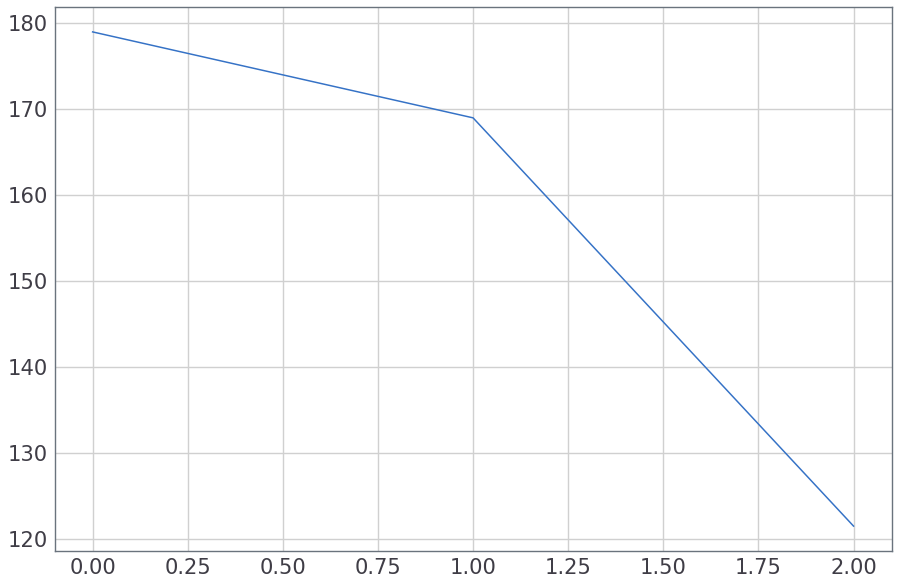

In [30]:
plot(groupmean(total_rewards, 10))

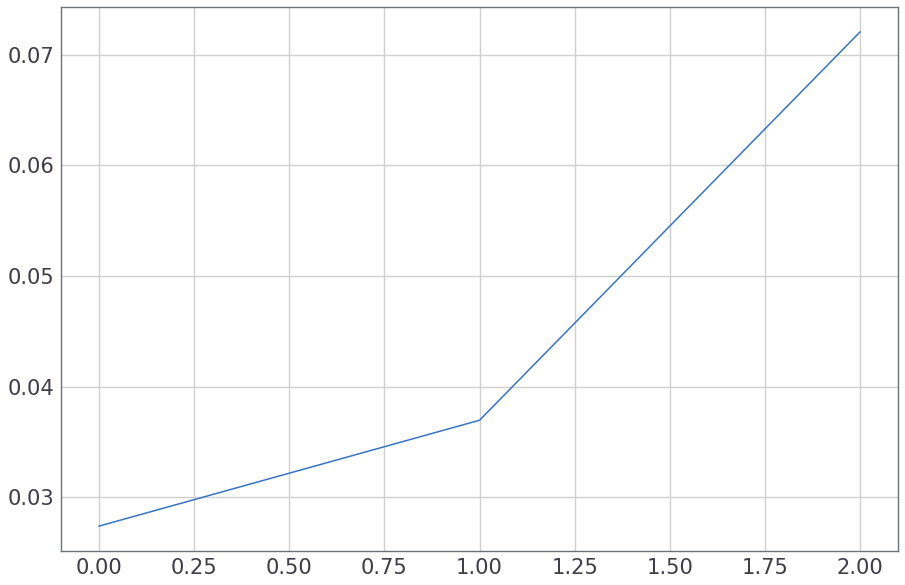

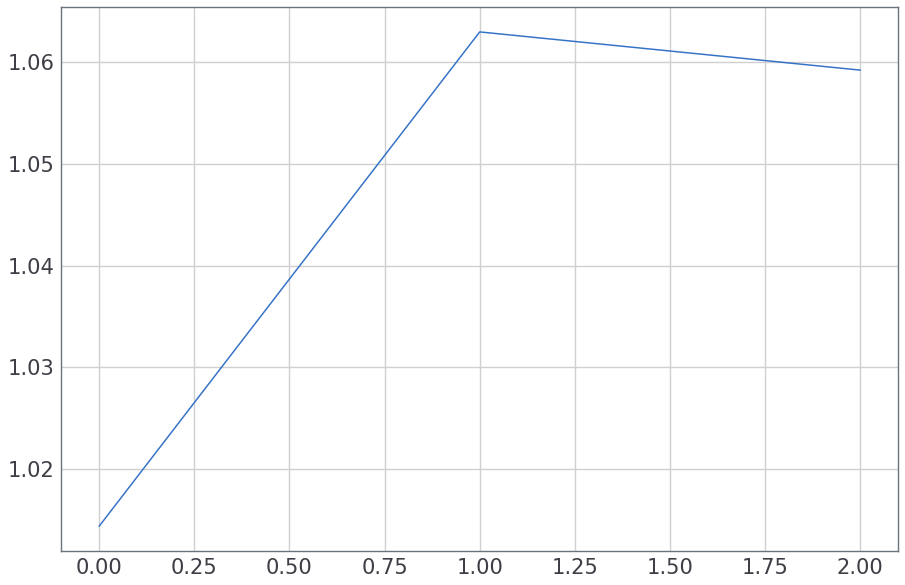

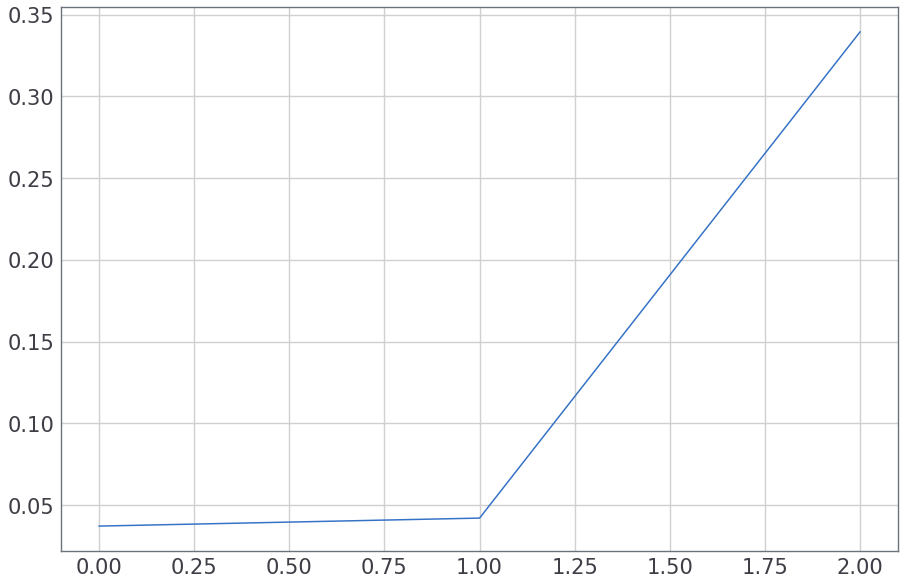

In [31]:
plot(groupmean(np.abs(actor_losses), 10)); plt.show()
plot(groupmean(np.abs(entropy_losses), 10)); plt.show()
plot(groupmean(critic_losses, 10)); plt.show()

In [32]:
test_one_episode(10000, probabilistic=False)

110.0

In [33]:
test_one_episode(10000, probabilistic=True)

210.0

In [35]:
for episode in range(1):
    state = normalize(env.reset())
    done = False
    r = 0

    for step in range(500):
        env.render()
        action = actor.act(state, probabilistic=True).item()
        with torch.no_grad():
            a = actor(torch.tensor(state, device=device)).cpu().numpy()
            print('Actor', a)
            print('Critic', critic(torch.tensor(state, device=device)).squeeze().item())
        state, reward, done, _ = env.step(rom_action(action))
        state = normalize(state)
        r += reward
        
        sleep(0.01)
        if done: break

    env.close()
    print(r)

Actor [-0.26030606 -0.21794493 -0.2865359 ]
Critic 0.3610687851905823
Actor [-0.2562111  -0.21836917 -0.23269445]
Critic 0.36668381094932556
Actor [-0.2784735  -0.22462232 -0.346937  ]
Critic 0.36835628747940063
Actor [-0.30697042 -0.24317795 -0.28131402]
Critic 0.3581410050392151
Actor [-0.29749817 -0.23336479 -0.40814131]
Critic 0.36379343271255493
Actor [-0.31204098 -0.2470514  -0.28597203]
Critic 0.3588109612464905
Actor [-0.22274844 -0.17299896 -0.43688083]
Critic 0.36716967821121216
Actor [-0.24448891 -0.19450694 -0.31990725]
Critic 0.3615167737007141
Actor [-0.27974278 -0.21639682 -0.46243924]
Critic 0.36339348554611206
Actor [-0.31965166 -0.27219576 -0.2079663 ]
Critic 0.36739927530288696
Actor [-0.279944   -0.23202029 -0.30570948]
Critic 0.3765668272972107
Actor [-0.32675678 -0.25532824 -0.2237879 ]
Critic 0.36663347482681274
Actor [-0.28022975 -0.22710271 -0.36110982]
Critic 0.3728553056716919
Actor [-0.24866931 -0.21386923 -0.24523541]
Critic 0.37377530336380005
Actor [-0.24

Actor [-0.2852797  -0.1503596   0.19708008]
Critic 0.6712501645088196
Actor [-0.4130305  -0.2801717   0.08557388]
Critic 0.6489607095718384
Actor [-0.3243286  -0.07374711 -0.18348017]
Critic 0.7631582617759705
Actor [-0.3827119  -0.09026265 -0.40990496]
Critic 0.7744573354721069
Actor [-0.40618497 -0.18069312 -0.172584  ]
Critic 0.7619348764419556
Actor [-0.42341495 -0.11784579 -0.5404928 ]
Critic 0.7506886124610901
Actor [-0.39027208 -0.17974997 -0.21543151]
Critic 0.761699378490448
Actor [-0.37789416 -0.11856259 -0.5211978 ]
Critic 0.7665796875953674
Actor [-0.4369104  -0.21055801 -0.29959926]
Critic 0.7446791529655457
Actor [-0.3711     -0.08380762 -0.7413428 ]
Critic 0.7272169589996338
Actor [-0.3724314  -0.09101835 -0.27215987]
Critic 0.784417986869812
Actor [-0.45301032 -0.17189202 -0.39124236]
Critic 0.7595465183258057
Actor [-0.32500142 -0.10782366 -0.40378755]
Critic 0.7675301432609558
Actor [-0.32236022 -0.13733451 -0.46556664]
Critic 0.7571036219596863
Actor [-0.38898033 -0.

Actor [-0.3265649  -0.04413129 -0.30862227]
Critic 0.8451904654502869
Actor [-0.3186322  -0.05966086 -0.22639492]
Critic 0.8371829986572266
Actor [-0.3233614  -0.00901129 -0.60684794]
Critic 0.8184909820556641
Actor [-0.31866485 -0.0498095  -0.22410968]
Critic 0.8357807397842407
Actor [-0.37996346 -0.08850577 -0.23426554]
Critic 0.8335163593292236
Actor [-0.32903725 -0.06990086 -0.09123612]
Critic 0.8388286828994751
Actor [-0.39839482 -0.07251636 -0.46201235]
Critic 0.8118990659713745
Actor [-0.46666545 -0.07965387 -0.3826763 ]
Critic 0.7947484254837036
Actor [-0.44203693 -0.08572337 -0.33121008]
Critic 0.8320044279098511
Actor [-0.43219584 -0.07958123 -0.26865205]
Critic 0.8214862942695618
Actor [-0.42973965 -0.07558115 -0.42174065]
Critic 0.8269590139389038
Actor [-0.34406233  0.00805394 -0.34194264]
Critic 0.832490086555481
Actor [-0.3748759  -0.03643838 -0.46907973]
Critic 0.8368456363677979
Actor [-0.38750482 -0.01309784 -0.3987997 ]
Critic 0.8194433450698853
Actor [-0.40095216 -0

Actor [-0.43814248 -0.06979507 -0.15459836]
Critic 0.9051984548568726
Actor [-0.43422836 -0.0869115  -0.3694289 ]
Critic 0.9100451469421387
Actor [-0.40775996 -0.09387378  0.00354142]
Critic 0.9278439283370972
Actor [-0.30593717 -0.03764599 -0.24019289]
Critic 0.9563575983047485
Actor [-0.3440225  -0.0955599   0.06568588]
Critic 0.9491148591041565
Actor [-0.33913428 -0.14080662 -0.22438699]
Critic 0.9416986107826233
Actor [-0.25431895 -0.10151768  0.10555422]
Critic 0.8052771687507629
Actor [-0.35628724 -0.16169748 -0.43146002]
Critic 0.7958081960678101
Actor [-0.36396873 -0.13724813 -0.12789023]
Critic 0.8554787635803223
Actor [-0.3252824  -0.12184918 -0.31257448]
Critic 0.8640806674957275
Actor [-0.3561827  -0.14515236 -0.16135591]
Critic 0.8586006760597229
Actor [-0.31711626 -0.12068246 -0.3589505 ]
Critic 0.86784827709198
Actor [-0.34464806 -0.10081504 -0.4742301 ]
Critic 0.8393020629882812
Actor [-0.34584814 -0.10306638 -0.6197647 ]
Critic 0.8356362581253052
Actor [-0.29932225  0.

Actor [-0.42252654 -0.0509669  -0.18054202]
Critic 0.8017405271530151
Actor [-0.40813488 -0.02628449 -0.0096869 ]
Critic 0.8137081861495972
Actor [-0.41603357 -0.04874659 -0.18256387]
Critic 0.8030330538749695
Actor [-0.42398787 -0.05539634 -0.12964046]
Critic 0.7950438857078552
Actor [-0.39436412 -0.03092628 -0.272722  ]
Critic 0.8018985390663147
Actor [-0.3938504  -0.02857986 -0.22029385]
Critic 0.7963763475418091
320.0
